<a href="https://colab.research.google.com/github/fwilhelmy/IFT6135-2025/blob/main/HW1_2025/assignment1_release/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135/HW1_2025/assignment1_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [2]:
%matplotlib inline
import warnings

from main import Arguments, run_experiment
from utils import save_model, load_model, generate_plots, cross_entropy_loss
from torchsummary import summary
import shutil
import torch

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [3]:
import unittest
import testy
suite = unittest.TestLoader().loadTestsFromModule(testy)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (testy.TestLinear.test_linear_attributes) ... ok
test_linear_forward (testy.TestLinear.test_linear_forward) ... ok
test_activation (testy.TestMLP.test_activation) ... ok
test_forward (testy.TestMLP.test_forward) ... ok
test_mlp (testy.TestMLP.test_mlp) ... ok
test_mixer_block (testy.TestMLPMixer.test_mixer_block) ... ok
test_mlpmixer (testy.TestMLPMixer.test_mlpmixer) ... ok
test_patch_emb (testy.TestMLPMixer.test_patch_emb) ... ok
test_basic_block (testy.TestResNet.test_basic_block) ... ok
test_basic_block2 (testy.TestResNet.test_basic_block2) ... ok
test_resnet (testy.TestResNet.test_resnet) ... ok
test_ce_loss (testy.TestUtils.test_ce_loss) ... ok

----------------------------------------------------------------------
Ran 12 tests in 1.204s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

# Experiments

## Experiment 1

For the MLP architecture, investigate the effect of the choice of non-linearity while keeping the other hyperparameters the same as the default. You are expected to provide four figures corresponding to training loss, validation loss, training accuracy, and validation accuracy, where the x-axis is the number of epochs. For each figure, use the legend to denote the non-linearity being used. Conclude which non-linearity is the best and give your explanation. Optionally, we provide the plotting utility function in utils.py

In [59]:
experiment1 = {
    "mlp_relu": Arguments(logdir="results/experiment1/mlp_relu", model='mlp', model_config='model_configs/mlp/mlp_relu.json'),
    "mlp_sigmoid": Arguments(logdir="results/experiment1/mlp_sigmoid", model='mlp', model_config='model_configs/mlp/mlp_sigmoid.json'),
    "mlp_tanh": Arguments(logdir="results/experiment1/mlp_tanh", model='mlp', model_config='model_configs/mlp/mlp_tanh.json'),
}

In [ ]:
run_experiment(experiment1)

legend_names = ['ReLU', 'Sigmoid', 'Tanh']
logdirs = [experiment1[key].logdir for key in experiment1]

generate_plots(logdirs, legend_names, "results/experiment1")

In [ ]:
!zip -r experiment1.zip results/experiment1

## Experiment 2 

For the ResNet18 architecture, investigate the effect of learning rate with the Adam optimizer. Perform experiments with learning rates of 0.1, 0.01, 0.001, 0.0001, 0.00001. Provide the figures and explain your findings.

In [58]:
experiment2 = {
    "resnet18_lr1e-1": Arguments(logdir="results/experiment2/resnet18_lr1e-1", model='resnet18', model_config='model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-1),
    "resnet18_lr1e-2": Arguments(logdir="results/experiment2/resnet18_lr1e-2", model='resnet18', model_config='model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-2),
    "resnet18_lr1e-3": Arguments(logdir="results/experiment2/resnet18_lr1e-3", model='resnet18', model_config='model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-3),
    "resnet18_lr1e-4": Arguments(logdir="results/experiment2/resnet18_lr1e-4", model='resnet18', model_config='model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-4),
    "resnet18_lr1e-5": Arguments(logdir="results/experiment2/resnet18_lr1e-5", model='resnet18', model_config='model_configs/resnet18.json', optimizer='adam', epochs=10, lr=1e-5),
}

In [ ]:
run_experiment(experiment2)

legend_names = ['1e-1', '1e-2', '1e-3', '1e-4', '1e-5']
logdirs = [experiment2[x].logdir for x in experiment2]

generate_plots(logdirs, legend_names, "results/experiment2")

In [ ]:
!zip -r experiment2.zip results/experiment2

## Experiment 3

For MLPMixer, investigate the effect of patch size. No recommended values are given, and you are expected to run at least 3 experiments. Remember there are only a few valid values for patch size for the given image size. Please provide figures and explain your findings. Also explain in text the effect on the number of model parameters and running time.

In [62]:
experiment3 = {
    "mlpmixer_patch2": Arguments(logdir="results/experiment3/mlpmixer_patch2", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch2.json', epochs=15),
    "mlpmixer_patch4": Arguments(logdir="results/experiment3/mlpmixer_patch4", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch4.json', epochs=15),
    "mlpmixer_patch8": Arguments(logdir="results/experiment3/mlpmixer_patch8", model='mlpmixer', model_config='model_configs/mlpmixer/mlpmixer_patch8.json', epochs=15)
}

In [ ]:
run_experiment(experiment3)

legend_names = ['Patch 2', 'Patch 4', 'Patch 8']
logdirs = [experiment3[x].logdir for x in experiment3]

generate_plots(logdirs, legend_names, "results/experiment3")

In [ ]:
!zip -r experiment3.zip results/experiment3

## Experiment 4

Find your best ResNet18 model by experimenting with different hyper-parameter choices. Provide the hyperparameters in your report. Visualize the kernels of the first layer, which has a weight of shape (out channel, in channel, kernel size, kernel size). You can modify the main.py or add extra cell in main.ipynb for visualization. Since we have 64 output channels and 3 input channels (RGB), one can view this as sixty-four 3 × 3 small images, where each image represent the kernel corresponding to that output channel. Note that this is an open-ended question. You can perform different pre-processing for visualization, e.g., standardizing the weight values, averaging across the channels to have gray scale images etc. You can see more details and examples in this blogpost. Please describe your visualization procedure in your report.

---

### SGD Without Momentum
Empirical evidence over the years shows that training deep CNNs like ResNet18 using plain SGD (i.e., without momentum) generally converges more slowly and may get stuck in poor local minima. Momentum helps accelerate SGD in the relevant direction and dampens oscillations, resulting in faster convergence and often better final performance.Given that momentum is a simple addition (and a well-established best practice), we prefer to compare only SGD with momentum.

### Adam
While Adam is a powerful adaptive optimizer in many settings, research in computer vision has demonstrated that, for training architectures like ResNet, plain Adam often does not generalize as well as either SGD with momentum or AdamW. AdamW improves upon Adam by decoupling weight decay from the adaptive updates, which typically results in better performance on vision tasks. Therefore, instead of plain Adam, we choose AdamW as the representative adaptive optimizer.

---

### Experiment 1: Baseline with SGD + Momentum
This is the standard baseline configuration for training ResNet18 on CIFAR-10. The combination of SGD with momentum (0.9) is well established for CNNs, and a learning rate of 0.01 is a typical starting point. A weight decay of 5e-4 provides reasonable regularization without overly penalizing the weights.

**Settings:**
- Optimizer: SGD with momentum
- Momentum: 0.9
- Learning Rate: 0.01
- Weight Decay: 5e-4

---

### Experiment 2: Increased Weight Decay with SGD + Momentum
By increasing the weight decay to 1e-3, this experiment tests whether stronger regularization can help reduce overfitting and improve validation performance, especially if the baseline shows signs of overfitting.

**Settings:**
- Optimizer: SGD with momentum
- Momentum: 0.9
- Learning Rate: 0.01
- Weight Decay: 1e-3

---

### Experiment 3: Higher Learning Rate with SGD + Momentum
This experiment raises the learning rate to 0.1 to evaluate whether a larger step size can accelerate convergence. However, it will also help determine if the increased learning rate introduces instability or divergence during training.

**Settings:**
- Optimizer: SGD with momentum
- Momentum: 0.9
- Learning Rate: 0.1
- Weight Decay: 5e-4

---

### Experiment 4: Using AdamW Optimizer
AdamW is an adaptive optimizer that decouples weight decay from the gradient update. It often converges faster and can be more robust to hyperparameter settings. Here, we compare its performance with the SGD + momentum baseline. The typical learning rate for AdamW is lower (1e-3) compared to SGD.

**Settings:**
- Optimizer: AdamW
- Learning Rate: 1e-3
- Weight Decay: 5e-4

In [3]:
experiment4 = {
    "resnet18_SGDMomentum_baseline": Arguments(
        logdir="results/experiment4/resnet18_SGDMomentum_baseline",
        model='resnet18',
        model_config='model_configs/resnet18.json',
        optimizer='momentum',
        lr=0.01,
    ),
    "resnet18_SGDMomentum_wd1e-3": Arguments(
        logdir="results/experiment4/resnet18_SGDMomentum_wd1e-3",
        model='resnet18',
        model_config='model_configs/resnet18.json',
        optimizer='momentum',
        lr=0.01,
        weight_decay=1e-3, # increased weight decay
    ),
    "resnet18_SGDMomentum_lr1e-1": Arguments(
        logdir="results/experiment4/resnet18_SGDMomentum_lr1e-1",
        model='resnet18',
        model_config='model_configs/resnet18.json',
        optimizer='momentum',
        lr=0.1, # higher learning rate
    ),
    "resnet18_AdamW": Arguments(
        logdir="results/experiment4/resnet18_AdamW",
        model='resnet18',
        model_config='model_configs/resnet18.json',
        optimizer='adamw',
    ),
}

In [ ]:
run_experiment(experiment4)

legend_names = ["SGD Momentum (Baseline)", "SGD Momentum (WD=1e-3)", "SGD Momentum (LR=0.1)", "AdamW"]
logdirs = [experiment4[x].logdir for x in experiment4]

generate_plots(logdirs, legend_names, "results/experiment4")

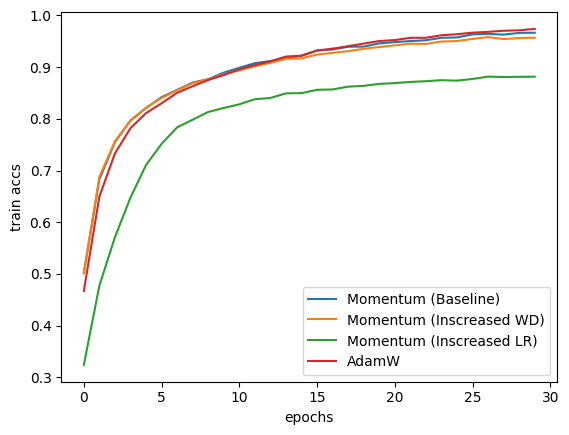

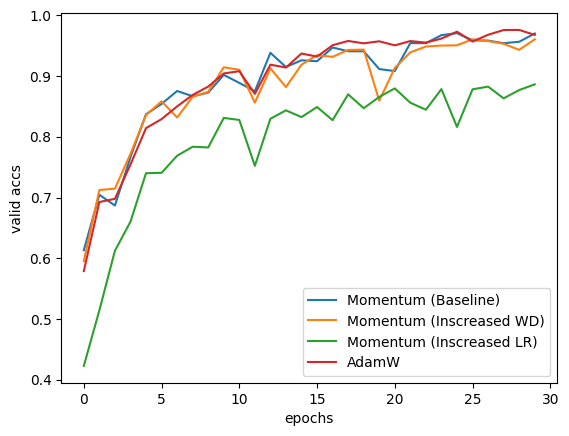

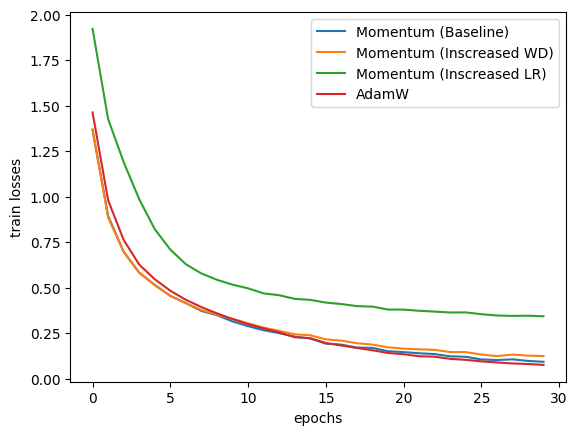

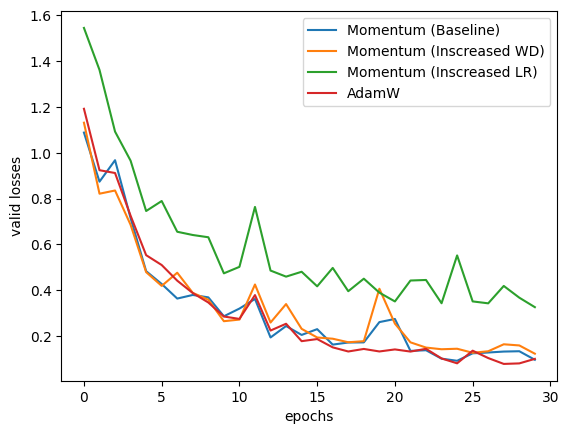

In [4]:
legend_names = ["Momentum (Baseline)", "Momentum (Inscreased WD)", "Momentum (Inscreased LR)", "AdamW"]
logdirs = [experiment4[x].logdir for x in experiment4]

generate_plots(logdirs, legend_names, "results/experiment4")

In [ ]:
for logdir in logdirs:
    model = load_model(logdir, torch.device('cpu'))
    model.visualize(logdir)

In [ ]:
!zip -r experiment4.zip results/experiment4

## Experiment 5

Set the patch size to be 4, and find hyper-parameters for your best MLPMixer model. Provide the full hyper-parameters in your report. Visualize the weights (only first layer) of token-mixing MLP in the first block as is described in Figure 5 of the MLPMixer paper. Comment and compare your results with the convolution visualizations. Explain what you think is the reason behind the success of the MLPMixer, especially over normal MLP?

---

### 1. MLPMixer Patch4 Baseline

This experiment is already trained and is the default configuration observed in question 4.4 for patch size 4. It serves as a reference point for all subsequent modifications.

**Configuration:**
- Optimizer: AdamW  
- Learning Rate: 1e-3  
- Weight Decay: 5e-4  
- Epochs: 15  
- Device: CUDA (if available)  
- Patch Size: 4  
- Embedding Dimension: 256  
- Number of Mixer Blocks: 4  
- Dropout Rate: 0.0  
- Activation: GELU

---

### 2. MLPMixer Patch4 with Dropout

This experiment introduces a dropout rate of 0.1 to the baseline configuration to help regularize the model and reduce overfitting.

**Configuration changes:**  
- Dropout Rate: 0.1  

**Analysis:**  
- Examine training vs. validation loss curves for reduced overfitting.  
- Look for a narrowing gap between training and validation accuracy.  
- Determine if the added dropout improves generalization compared to the baseline.

---

### 3. MLPMixer Patch4 with Embedding Dimension 512 (Increased Embedding Experiment)

This experiment increases the embedding dimension from 256 to 512, aiming to capture richer representations for each patch.

**Configuration changes:**  
- Embedding Dimension: 512  

**Analysis:**  
- Evaluate whether the higher capacity leads to improved validation accuracy.  
- Monitor for potential overfitting due to the increased number of parameters.  
- Compare feature quality and training dynamics against the baseline.

---

### 4. MLPMixer Patch4 with 8 Mixer Blocks (Deeper Model Experiment)

This experiment doubles the number of MixerBlocks from 4 to 8 while keeping the embedding dimension at 256. The goal is to assess if additional depth improves the mixing of token information.

**Configuration changes:**
- Number of Mixer Blocks: 8  

**Analysis:**  
- Investigate improvements in capturing higher-level interactions between patches.  
- Observe the impact on training time and whether deeper mixing leads to better validation performance.  
- Look for signs of overfitting as the model depth increases.

---

### 5. MLPMixer Patch4 with Increased Capacity and Dropout

This experiment combines the modifications from Experiments 3 and 4 by increasing both the embedding dimension to 512 and the number of MixerBlocks to 8, while also adding a dropout rate of 0.1. This tests the upper bound of capacity while controlling overfitting.

**Configuration changes:**
- Embedding Dimension: 512  
- Number of Mixer Blocks: 8  

**Analysis:**  
- Compare the training and validation performance with all other experiments.  
- Assess whether the combined increases in capacity and depth, along with dropout, yield the best generalization.  
- Evaluate the token-mixing MLP visualizations (if available) to see if the model learns richer spatial interactions.  
- Use these insights to decide if the extra complexity is justified by improved performance.

---

In [ ]:
experiment5 = {
    # "mlpmixer_dropout": Arguments(
    #     logdir="results/experiment5/mlpmixer_dropout",
    #     model='mlpmixer',
    #     model_config='model_configs/mlpmixer/mlpmixer_dropout.json',
    # ),
    # "mlpmixer_embed512": Arguments(
    #     logdir="results/experiment5/mlpmixer_embed512",
    #     model='mlpmixer',
    #     model_config='model_configs/mlpmixer/mlpmixer_embed512.json',
    # ),
    # "mlpmixer_deep": Arguments(
    #     logdir="results/experiment5/mlpmixer_deep",
    #     model='mlpmixer',
    #     model_config='model_configs/mlpmixer/mlpmixer_deep.json',
    # ),
    "mlpmixer_combined": Arguments(
        logdir="results/experiment5/mlpmixer_combined",
        model='mlpmixer',
        model_config='model_configs/mlpmixer/mlpmixer_combined.json',
    ),
    "mlpmixer_combined_dropout": Arguments(
        logdir="results/experiment5/mlpmixer_combined_dropout",
        model='mlpmixer',
        model_config='model_configs/mlpmixer/mlpmixer_combined_dropout.json',
    )
}

In [ ]:
run_experiment(experiment5)

# Since the baseline experiment was already done in experiment 3, just copy the results to experiment 5 results
shutil.copytree("results/experiment3/mlpmixer_patch4", "results/experiment5/mlpmixer_baseline")

legend_names = ["Baseline", "Dropout", "Embedding 512", "Deep", "Combined"]
logdirs = ["results/experiment5/mlpmixer_baseline"] + [experiment5[x].logdir for x in experiment5]

generate_plots(logdirs, legend_names, "results/experiment5")

In [ ]:
for logdir in logdirs:
    model = load_model(logdir, torch.device('cpu'))
    model.visualize(1, logdir)

In [ ]:
!zip -r experiment5.zip results/experiment5

## Experiment 6

This experiment investigates how the allocation of capacity between the token-mixing and channel-mixing MLPs affects performance. We vary the mlp_ratio parameter, which controls the hidden dimensions of each MLP relative to the embedding dimension, to see how different balances influence learning dynamics and generalization on CIFAR-10.

By comparing these configurations, we will gain insight into how different capacity distributions between token mixing and channel mixing affect the model's ability to learn both spatial and feature representations. I will analyze the loss and accuracy curves for each experiment, and consider any qualitative visualizations (e.g., weight heatmaps) to support my conclusions.


---

### 1. Baseline (Default)

This configuration uses the default asymmetric mlp_ratio values on a pre-trained model from question 4.4.

**Configuration:**
- **Patch Size:** 4 (yielding an 8×8 grid for a 32×32 image)
- **Embedding Dimension:** 256
- **Number of MixerBlocks:** 4
- **Dropout Rate:** 0.1
- **Activation Function:** GELU
- **mlp_ratio:** [0.5, 4.0]
  - *Token-Mixing hidden size:* 0.5 × 512 = 256  
  - *Channel-Mixing hidden size:* 4.0 × 512 = 2048

**Analysis:**
- Use this configuration as the reference baseline.
- Examine training and validation loss/accuracy curves.
- Assess if the model achieves a good balance between underfitting and overfitting.

---

### 2. Increased Token-Mixing Capacity

This configuration increases the capacity of the token-mixing MLP, aiming to better capture spatial (inter-patch) relationships while keeping channel-mixing capacity unchanged.

**Configuration:**
- **mlp_ratio:** [1.0, 4.0]
  - *Token-Mixing hidden size:* 1.0 × 512 = 512  
  - *Channel-Mixing hidden size:* 4.0 × 512 = 2048

**Analysis:**
- Determine if enhancing token mixing improves spatial information aggregation.
- Compare validation performance against the baseline.
- Look for improvements in generalization or signs of overfitting (e.g., a large gap between training and validation metrics).

---

### 3. Increased Channel-Mixing Capacity

This configuration boosts the capacity of the channel-mixing MLP to enable richer intra-token feature transformation, potentially leading to better feature representations.

**Configuration:**
- **mlp_ratio:** [0.5, 8.0]
  - *Token-Mixing hidden size:* 0.5 × 512 = 256  
  - *Channel-Mixing hidden size:* 8.0 × 512 = 4096

**Analysis:**
- Evaluate whether increasing channel mixing improves intra-patch feature extraction.
- Check for higher training accuracy accompanied by overfitting.
- Examine if the enhanced channel capacity translates to improved validation accuracy.

---

### 4. Balanced Capacity for Both Mixings

This configuration allocates equal capacity to both token and channel mixing, challenging the assumption of asymmetry by treating spatial and feature processing equally.

**Configuration:**
- **mlp_ratio:** [1.0, 1.0]
  - *Token-Mixing hidden size:* 1.0 × 512 = 512  
  - *Channel-Mixing hidden size:* 1.0 × 512 = 512

**Analysis:**
- Assess whether equal capacity for token and channel mixing yields a more balanced performance.
- Compare training and validation metrics with the asymmetric configurations.
- Determine if the balanced design leads to stable training and improved generalization.

In [49]:
experiment6 = {
    "mlpmixer_increased_token": Arguments(
        logdir="results/experiment6/mlpmixer_increased_token",
        model='mlpmixer',
        model_config='model_configs/mlpmixer/mlpmixer_increased_token.json',
    ),
    "mlpmixer_increased_channel": Arguments(
        logdir="results/experiment6/mlpmixer_increased_channel",
        model='mlpmixer',
        model_config='model_configs/mlpmixer/mlpmixer_increased_channel.json',
    ),
    "mlpmixer_balanced_ratio": Arguments(
        logdir="results/experiment6/mlpmixer_balanced_ratio",
        model='mlpmixer',
        model_config='model_configs/mlpmixer/mlpmixer_balanced_ratio.json',
    )
}

In [ ]:
run_experiment(experiment6)

# Since the baseline experiment was already done in experiment 3, just copy the results to experiment 6 results
shutil.copytree("results/experiment3/mlpmixer_patch4", "results/experiment6/mlpmixer_baseline")

legend_names = ["Baseline", "Increased Token", "Increased Channel", "Balanced Ratio"]
logdirs = ["results/experiment6/mlpmixer_baseline"] + [experiment6[x].logdir for x in experiment6]

generate_plots(logdirs, legend_names, f"results/experiment6")

In [ ]:
for logdir in logdirs:
    model = load_model(logdir, torch.device('cpu'))
    model.visualize(1, logdir)

In [ ]:
!zip -r experiment6.zip results/experiment6

## Experiment 7

Compare the gradient flow (e.g., norms of gradients at different layers) during backpropagation for all three architectures (MLP, ResNet18 and MLPMixer). Analyze and compare the behavior of gradients in each architecture.

In [ ]:
experiment7 = {}

run_experiment(experiment7)

legend_names = []
logdirs = []

generate_plots(logdirs, legend_names, f"results/experiment7")

In [ ]:
!zip -r experiment7.zip results/experiment7

## Block for running all experiments in one go

In [ ]:
experiments = [experiment1, experiment2, experiment3, experiment4, experiment5, experiment6]

for experiment in experiments:
    # update all contents in experiment to have 30 epochs
    for key in experiment:
        experiment[key].epochs = 30 
    run_experiment(experiment, True, 1)

shutil.copytree("results/experiment3/mlpmixer_patch4", "results/experiment5/mlpmixer_baseline")
shutil.copytree("results/experiment3/mlpmixer_patch4", "results/experiment6/mlpmixer_baseline")

legend_names = [["ReLU", "Sigmoid", "Tanh"], [x for x in experiment2], [x for x in experiment3.keys()], ["SGDMomentum_baseline", "SGDMomentum_wd1e-3", "SGDMomentum_lr1e-1", "AdamW"], ["Baseline", "Dropout", "Embedding 512", "Deep", "Combined"], ["Baseline", "Increased Token", "Increased Channel", "Balanced Ratio"]]
logdirs = [[experiment1[key].logdir for key in experiment1], [experiment2[x].logdir for x in experiment2], [experiment3[x].logdir for x in experiment3], [experiment4[x].logdir for x in experiment4], ["results/experiment5/mlpmixer_base"] + [experiment5[x].logdir for x in experiment5], ["results/experiment6/mlpmixer_base"] + [experiment6[x].logdir for x in experiment6]]

for i, experiment in enumerate(experiments):
    generate_plots(logdirs[i], legend_names[i], f"results/experiment{i+1}")

In [ ]:
import os
import json
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import cross_entropy_loss, load_model
from metrics import convergence_speed, stability, gradient_norms

# Set up experiment configuration and identifier
experiment_id = "experiment3"
experiment = experiment3

# 1. Aggregate results from each experiment into one JSON file
all_results = {}
for exp_name, args in experiment.items():
    results_file = os.path.join(args.logdir, "results.json")
    with open(results_file, "r") as f:
        all_results[exp_name] = json.load(f)

results_save_path = os.path.join("results", experiment_id, "results.json")
with open(results_save_path, "w") as f:
    json.dump(all_results, f, indent=4)

# 2. Define transforms and dataloaders for CIFAR-10
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
])

test_dataset = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

train_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# 3. Generate metrics.txt by writing computed metrics for each experiment
metrics_save_path = os.path.join("results", experiment_id, "metrics.txt")
with open(metrics_save_path, "w") as metrics_file:
    for exp_name, args in experiment.items():
        results_file = os.path.join(args.logdir, "results.json")
        with open(results_file, "r") as f:
            results = json.load(f)
        
        # Load model (assumes load_model is defined in your utils)
        model = load_model(args.logdir, torch.device('cpu'))
        
        # Compute convergence speed (epoch when validation accuracy first reaches 65%)
        conv_epoch = convergence_speed(results["valid_accs"], threshold=0.65)
        metrics_file.write(f"Experiment {exp_name}: Convergence epoch = {conv_epoch}\n")
        
        # Compute stability: variance of training and validation accuracy over the last 5 epochs
        train_acc_var = stability(results["train_accs"], last_n=5)
        valid_acc_var = stability(results["valid_accs"], last_n=5)
        metrics_file.write(f"Experiment {exp_name}: Training accuracy variance (last 5 epochs) = {train_acc_var:.4f}\n")
        metrics_file.write(f"Experiment {exp_name}: Validation accuracy variance (last 5 epochs) = {valid_acc_var:.4f}\n")
        
        # Compute gradient norms for one batch from the training dataloader
        grad_norms_val = gradient_norms(model, train_dataloader, 'cpu')
        metrics_file.write(f"Experiment {exp_name}: Gradient norms (first batch) = {grad_norms_val}\n")

# 4. Generate summary.txt by aggregating each experiment's summary file
summary_save_path = os.path.join("results", experiment_id, "summary.txt")
with open(summary_save_path, "w") as outfile:
    for config_key, args_obj in experiment.items():
        outfile.write(f"### {config_key}\n\n")
        summary_file = os.path.join(args_obj.logdir, "summary.txt")
        if os.path.exists(summary_file):
            with open(summary_file, "r") as infile:
                content = infile.read()
            outfile.write(content)
        else:
            outfile.write("Summary file not found.\n")
        outfile.write("\n\n")

# 5. Generate the final aggregated file that combines all the outputs
final_save_path = os.path.join("results", experiment_id, "final.txt")

# (a) Experiment configuration: convert experiment object to a JSON string.
# Here we assume that the experiment values are simple objects; if not, you might need to
# manually extract the serializable attributes.
experiment_config_str = json.dumps({exp_name: vars(args) for exp_name, args in experiment.items()}, indent=4)

# (b) Model configurations: for each experiment, load the .model_config file (assumed to be JSON).
models_config = {}
for exp_name, args in experiment.items():
    model_config_path = args.model_config
    if os.path.exists(model_config_path):
        with open(model_config_path, "r") as f:
            models_config[exp_name] = json.load(f)
    else:
        models_config[exp_name] = f"Model configuration {model_config_path} not found."

models_config_str = json.dumps(models_config, indent=4)

# (c) Read the aggregated results (raw results) from results.json
with open(results_save_path, "r") as f:
    results_content = f.read()

# (d) Read the summary from summary.txt
with open(summary_save_path, "r") as f:
    summary_content = f.read()

# (e) Read the additional metrics from metrics.txt
with open(metrics_save_path, "r") as f:
    metrics_content = f.read()

# Combine everything in the final file content according to the given template
final_content = f"""Okay now let's move on to the next question X. Here is more information about the experiment for question X:

Here is the configuration of the experiments of the question:
{experiment_config_str}

Here is the models configuration:
{models_config_str}

Here is the raw results of the training process:
{results_content}

Here is the summary of every model architecture:
{summary_content}
"""

with open(final_save_path, "w") as final_file:
    final_file.write(final_content)
